# A Brief Feel for the Dream

In [1]:
using Distributed
addprocs(4)
@everywhere begin 
    using DistributedArrays
    using LinearAlgebra
end
using CUDA
import CUDA: @time
using BenchmarkTools

┌ Warning: CUDA runtime library `libcublasLt.so.12` was loaded from a system path, `/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/math_libs/12.4/lib64/libcublasLt.so.12`.
│ This may cause errors.
│ 
│ If you're running under a profiler, this situation is expected. Otherwise,
│ ensure that your library path environment variable (e.g., `PATH` on Windows
│ or `LD_LIBRARY_PATH` on Linux) does not include CUDA library paths.
│ 
│ In any other case, please file an issue.
└ @ CUDA ~/.julia/packages/CUDA/oymHm/src/initialization.jl:218
┌ Warning: CUDA runtime library `libnvJitLink.so.12` was loaded from a system path, `/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/cuda/12.4/lib64/libnvJitLink.so.12`.
│ This may cause errors.
│ 
│ If you're running under a profiler, this situation is expected. Otherwise,
│ ensure that your library path environment variable (e.g., `PATH` on Windows
│ or `LD_LIBRARY_PATH` on Linux) does not include CUDA library paths.
│ 
│ In any other case, please file an issue.
└ @ CUDA ~/.jul

      From worker 3:	┌ Warning: CUDA runtime library `libcublasLt.so.12` was loaded from a system path, `/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/math_libs/12.4/lib64/libcublasLt.so.12`.
      From worker 3:	│ This may cause errors.
      From worker 3:	│ 
      From worker 3:	│ If you're running under a profiler, this situation is expected. Otherwise,
      From worker 3:	│ ensure that your library path environment variable (e.g., `PATH` on Windows
      From worker 3:	│ or `LD_LIBRARY_PATH` on Linux) does not include CUDA library paths.
      From worker 3:	│ 
      From worker 3:	│ In any other case, please file an issue.
      From worker 3:	└ @ CUDA ~/.julia/packages/CUDA/oymHm/src/initialization.jl:218
      From worker 3:	┌ Warning: CUDA runtime library `libnvJitLink.so.12` was loaded from a system path, `/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/cuda/12.4/lib64/libnvJitLink.so.12`.
      From worker 3:	│ This may cause errors.
      From worker 3:	│ 
      From worker 3:	│ If you're r

## So you like linear algebra? <br>
<table style="width:100%">
  <tr>
    <th><img src="http://freecomputerbooks.com/covers/LAPACK-Users-Guide-Third-Edition.jpg" width="100"></th>
    <th><img src="http://www.netlib.org/scalapack/slug/slug_cover.gif"  width="100"></th>
      <th><img src="https://images-na.ssl-images-amazon.com/images/I/41uT31fSxBL._SX352_BO1,204,203,200_.jpg" width="100"></th>
    
  </tr>
    



## But you are innovating beyond the traditional libraries?

##  For demonstration let's make a matrix where you know more than the libraries know.

Let's create a custom  matrix structure that depends on n parameters, not $n^2$: <br> <br>
Diagonal(v) + v*v'
<br>

For example (n=3):
$$ \begin{pmatrix}
v_1 & & \\
& v_2 & \\
& & v_3
\end{pmatrix} + 
\begin{pmatrix}
v_1^2 & v_1 v_2 & v_1 v_3 \\
v_2 v_1 & v_2^2 & v_2 v_3 \\
v_3 v_1 & v_3 v_2 & v_3^2
\end{pmatrix} .
$$


# Build a Custom Type

In [2]:
struct MyMatrix{T, V<:AbstractVector{T}} <: AbstractMatrix{T}
   v::V
end

### Setting up a basic array type typically requires only two functions:

In [33]:
Base.size(A::MyMatrix)         =   length(A.v), length(A.v)
Base.getindex(A::MyMatrix, i, j) =   A.v[i]*(i==j)  + A.v[i]*A.v[j]

**You can add more overloads as needed for performance or correctness gradually**

In [4]:
A = MyMatrix([1,10,100])

3×3 MyMatrix{Int64, Vector{Int64}}:
   2    10    100
  10   110   1000
 100  1000  10100

In [5]:
dump( A )  # n storage

MyMatrix{Int64, Vector{Int64}}
Int64}((3,)) [1, 10, 100]


In [6]:
dump(Matrix(A)) # n² storage

Array{Int64}((3, 3)) [2 10 100; 10 110 1000; 100 1000 10100]


## My very own largest eigensolver for my very own matrices

**We will use Julia's array abstraction, specifically mapreduce, to perform all of the array calculations**

In [7]:
f(A::MyMatrix)  = λ ->  1 + mapreduce((v) -> v^2 / (v - λ), +, A.v)

f′(A::MyMatrix) = λ ->      mapreduce((v) -> v^2 / (v - λ)^2, +, A.v)

f′ (generic function with 1 method)

In [8]:
function LinearAlgebra.eigmax(A::MyMatrix; tol = eps(2.0))
    x0 = maximum(A.v) + maximum(A.v)^2
    δ = f(A)(x0)/f′(A)(x0)
    while abs(δ) > x0 * tol               
        x0 -= δ
        δ = f(A)(x0)/f′(A)(x0) 
    end
    x0
end

In [9]:
eigmax(A)

10200.107083707298

In [10]:
eigmax(Matrix(A))

10200.107083707298

## Go Heterogeneous

In [34]:
gpuA = MyMatrix(CuArray([1,2,3]))

3×3 MyMatrix{Int64, CuArray{Int64, 1, CUDA.DeviceMemory}}:
 2  2   3
 2  6   6
 3  6  12

## Go Distributed / Multiprocess

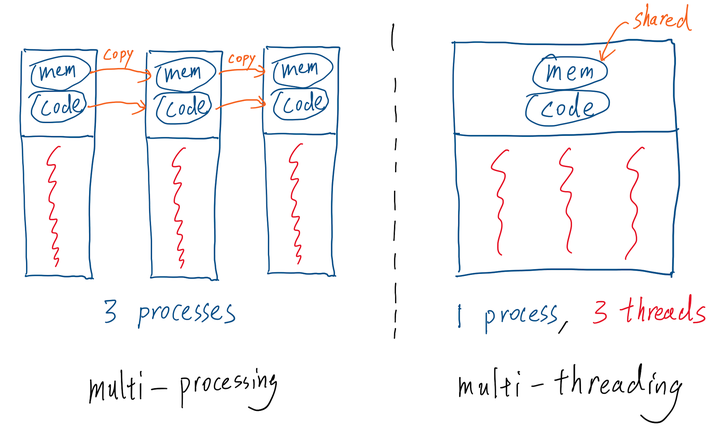

In [12]:
distA = MyMatrix(distribute([1,2,3]))

3×3 MyMatrix{Int64, DArray{Int64, 1, Vector{Int64}}}:
 2  2   3
 2  6   6
 3  6  12

In [13]:
Matrix(gpuA)

3×3 Matrix{Int64}:
 2  2   3
 2  6   6
 3  6  12

In [14]:
Matrix(distA)

3×3 Matrix{Int64}:
 2  2   3
 2  6   6
 3  6  12

# Compare Timings

In [15]:
N = 400_000_000

400000000

In [16]:
v = randn(N)*.1;

In [17]:
A = MyMatrix(v)

400000000×400000000 MyMatrix{Float64, Vector{Float64}}:
  0.0586016     0.00044152    0.00687139   …   0.00125971    0.00467368
  0.00044152    0.00801581    0.000984257      0.000180441   0.000669458
  0.00687139    0.000984257   0.139084         0.00280821    0.0104188
  0.00362904    0.000519824   0.00809003       0.00148312    0.00550256
  0.00156316    0.000223906   0.00348466       0.000638833   0.00237015
  0.00398572    0.000570914   0.00888514   …   0.00162889    0.00604337
 -0.00525281   -0.000752411  -0.0117098       -0.00214672   -0.0079646
 -0.00560357   -0.000802654  -0.0124917       -0.00229007   -0.00849645
 -0.00377421   -0.000540617  -0.00841363      -0.00154245   -0.00572266
 -0.00261424   -0.000374463  -0.00582777      -0.00106839   -0.00396385
  0.01102       0.0015785     0.0245663    …   0.00450367    0.0167091
  0.00624443    0.000894451   0.0139204        0.00255198    0.00946815
  0.000257197   3.68408e-5    0.000573354      0.000105111   0.000389976
  ⋮      

In [18]:
distA = MyMatrix(distribute(v));

In [19]:
gpuA = MyMatrix(CuArray(v));

In [20]:
@btime eigmax(A)

  9.870 s (1 allocation: 16 bytes)


4.000294717970958e6

In [21]:
@btime eigmax(distA)

  2.882 s (21018 allocations: 1.02 MiB)


4.000294717970958e6

**We started with 4 processes, but we're only ~2x faster?! Can anyone guess why?**

In [22]:
eigmax(gpuA) # run once to compile
t = (@elapsed eigmax(gpuA)) * 1000
println("$t ms")

159.358847 ms


## Can we do this with OhMyThreads?

### Yes but we have to create another new type :)

In [23]:
using OhMyThreads: tmapreduce, tmap, treduce

In [24]:
struct OhMyVector{T} <: AbstractVector{T}
    v::Vector{T}
end

In [25]:
Base.size(v::OhMyVector) = size(v.v)
Base.getindex(v::OhMyVector, i) = getindex(v.v, i)

**We need to add a new overload since we want OhMyVector to use a threaded mapreduce!**

In [26]:
Base.mapreduce(f, +, v::OhMyVector; kwargs...) = tmapreduce(f, +, v.v; kwargs..., ntasks = Threads.nthreads())

In [27]:
OhMyv = OhMyVector(v);

In [28]:
OhMyA = MyMatrix(OhMyv);

In [29]:
@btime eigmax(OhMyA)

  1.551 s (24086 allocations: 2.14 MiB)


4.0002947179709575e6

### We are a bit faster than multi-processing but definitely not 8x as fast! What gives?!

In [38]:
@btime tmapreduce(sin, +, v; ntasks = 1)
@btime tmapreduce(sin, +, v; ntasks = 2)
@btime tmapreduce(sin, +, v; ntasks = 4)
@btime tmapreduce(sin, +, v; ntasks = 16)

  2.724 s (1 allocation: 16 bytes)
  1.235 s (53 allocations: 2.22 KiB)
  636.690 ms (52 allocations: 2.88 KiB)
  179.970 ms (116 allocations: 9.50 KiB)


-588.3385471606593

In [31]:
f3(v) = v^2 / (v - 2.0)

f3 (generic function with 1 method)

In [32]:
@btime tmapreduce(f3, +, v; ntasks = 1)
@btime tmapreduce(f3, +, v; ntasks = 2)
@btime tmapreduce(f3, +, v; ntasks = 4)

  163.405 ms (1 allocation: 16 bytes)
  78.066 ms (28 allocations: 1.56 KiB)
  53.593 ms (40 allocations: 2.69 KiB)


-2.01533300221691e6

In [39]:
@btime tmapreduce(f3, +, v; ntasks = 16)
@btime tmapreduce(f3, +, v; ntasks = 32)

  59.917 ms (112 allocations: 9.44 KiB)
  61.256 ms (208 allocations: 18.44 KiB)


-2.0153330022169095e6

In [40]:
A = rand(2, 2)

2×2 Matrix{Float64}:
 0.58057    0.632647
 0.0646999  0.482628

LoadError: UndefVarError: `literal_pow` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# The curse of faster compute

### We keep getting faster CPU cores

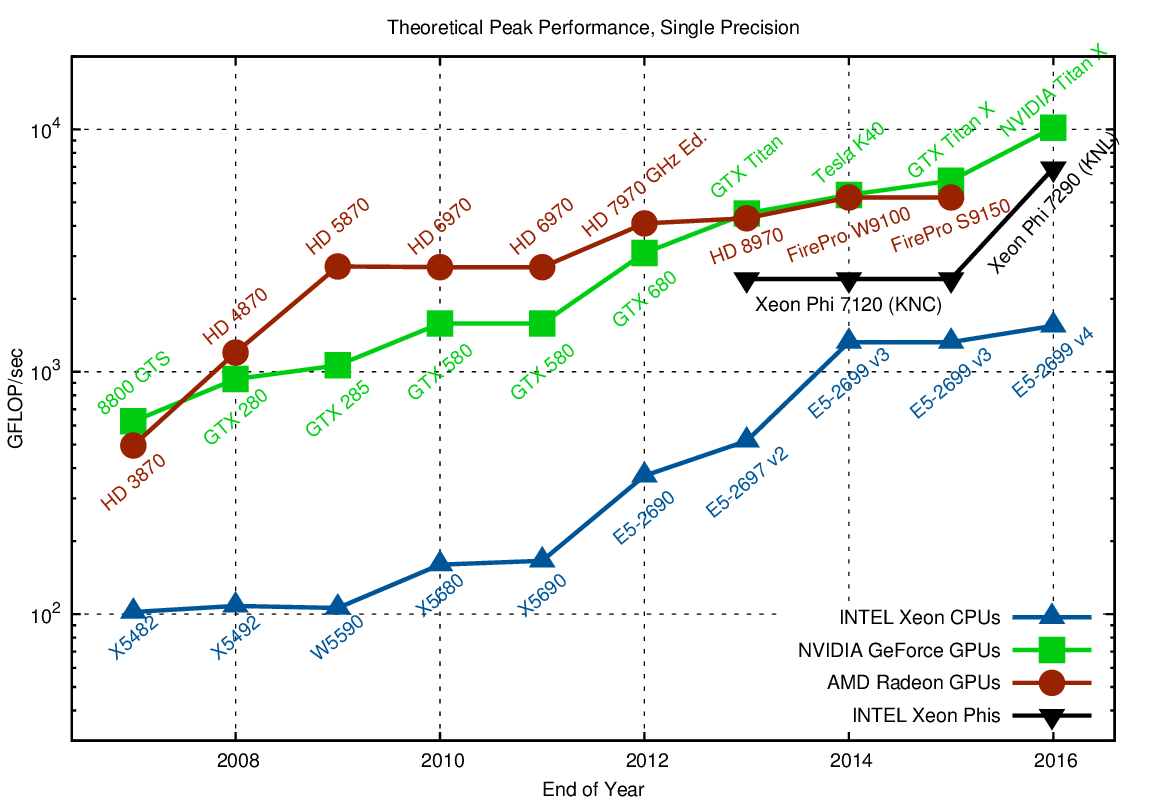

### But memory bandwidth isn't keeping up

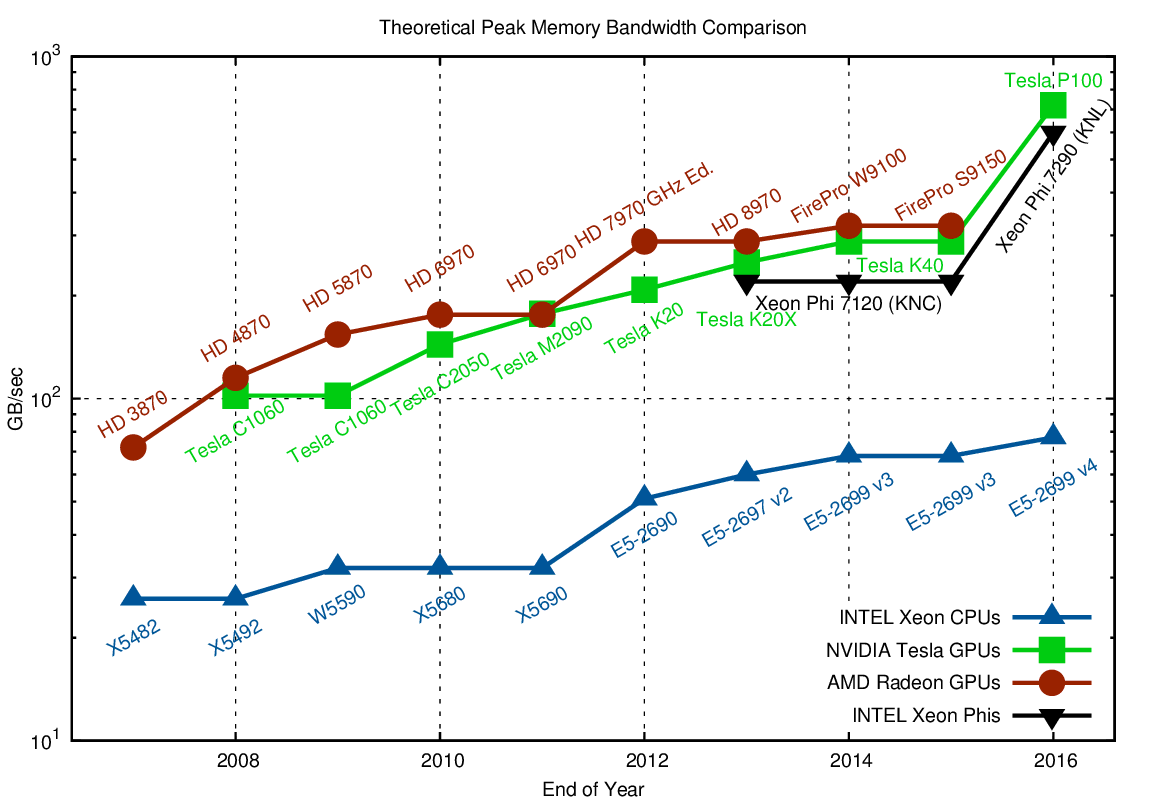

**This explains why our distributed and multithreaded code doesn't get any faster after 2 processes/threads despite having massively performant CPUs**

## Abstraction

1. A data structure is a mathematical matrix! <br>
2. A matrix can be serial, distributed, gpu <br>
BOTH ARE ABSTRACTIONS, BOTH use underlying similar mechanisms

## Why Julia?
1. Well designed abstractions <br>
2. Multiple dispatch <br>
3. Careful balance between static and dynamic <br>
4. Compiles to GPU at multiple levels, not just lowest CUDA level <br>
5. Metaprogramming across the stack <br>
6. Interfaces with LLVM <br>
7. Plays nicely with Python, legacy codes, ... <br>